NGÀY 1:

CHỦ ĐỀ: XỬ LÝ DỮ LIỆU ĐẦU VÀO LÀ CẢM BIẾN NHIỆT ĐỘ (Temperature Sensor).

TƯ DUY TỔNG QUÁT: Tôi đang đo cái gì? Đo để làm gì? và quyết định được gì khi dựa trên số liệu đó?.

Mục tiêu: 

    - Hiểu dữ liệu cảm biến là gì?.

    - Biết python xử lý dữ liệu sensor như thế nào?.

    - Dùng được: Biến, hàm, list, vòng lặp.

    - Vẽ được biểu đồ nhiệt độ theo thời gian, có lập ngưỡng overhead.

 Định nghĩa bài toán:

 Một motor trong nhà máy SMT có sensor nhiệt độ như sau:

    - Đo mỗi 10 giây, lấy tổng cộng 100 mẫu dữ liệu.

    - Nhiệt độ bình thường được xác định trong khoảng: 40-70 độ C.

    - Thiết lập ngưỡng cảnh báo quá nhiệt là 65 độ.

 Nhiệm vụ:

    - Cell 0: Import thư viện liên quan.

    - Cell 1: Tạo dữ liệu nhiệt độ, data type, làm tròn số.

    - Cell 2: Tạo timestamp(Tần suất lấy mẫu).

    - Cell 3: Lưu và in thông tin dữ liệu.

    - Cell 5: Phân tích dữ liệu cảm biến.

    - Cell 6: Biểu diễn biểu đồ.


In [1]:
import random
from decimal import*
import matplotlib.pyplot as plt

In [2]:
temperature_data = []

for sample in range(100):
    temp = Decimal(str(random.uniform(40,70))).quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)
    temperature_data.append(temp)  #sensor gửi dữ liệu
temperature_data[:3]

[Decimal('54.76'), Decimal('52.25'), Decimal('48.74')]

In [3]:
from datetime import*

timestamped_data = []
start_time = datetime.now() # Thời điểm bắt đầu đo
interval = timedelta(seconds=10)  # 10 giây lấy mẫu một lần

for i, temp in enumerate(temperature_data):
    record = {
        'timestamp': start_time + i * interval,
        'temperature': temp
    }
    timestamped_data.append(record)

timestamped_data[:1]

[{'timestamp': datetime.datetime(2026, 1, 7, 9, 38, 33, 989543),
  'temperature': Decimal('54.76')}]

In [4]:
max_temp = max(temperature_data)
min_temp = min(temperature_data)
avg_temp = sum(temperature_data) / len(temperature_data)

print(f"Max Temp: {max_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)} °C")
print(f"Min Temp: {min_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)} °C")
print(f"Average Temp: {avg_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)} °C")

Max Temp: 69.97 °C
Min Temp: 40.04 °C
Average Temp: 55.11 °C


In [5]:
def analyze_temperature(data):
    if not data:
        return None
    
    max_temp = max(data)
    min_temp = min(data)
    avg_temp = sum(data) / Decimal(len(data))
    
    return{
        "max": max_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP),
        "min": min_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP),
        "avg": avg_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)
    }
result = analyze_temperature(temperature_data)
result

{'max': Decimal('69.97'), 'min': Decimal('40.04'), 'avg': Decimal('55.11')}

In [6]:
times = [d["timestamp"] for d in timestamped_data]
temps = [float(d["temperature"]) for d in timestamped_data]

In [7]:
OVERHEAT_THRESHOLD = Decimal('65.00')

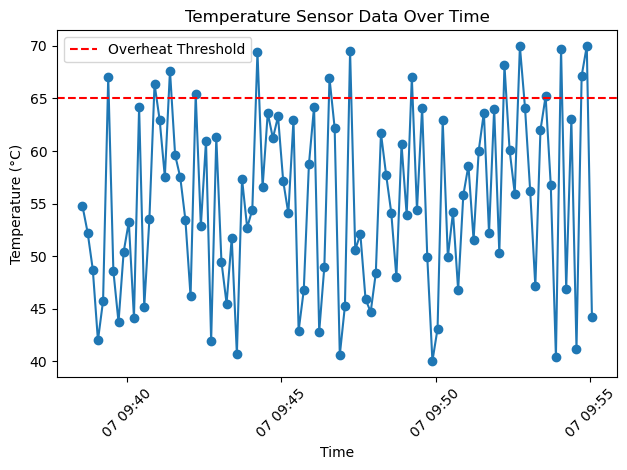

In [8]:
plt.figure()
plt.plot(times, temps, marker='o')
plt.axhline(y=float(OVERHEAT_THRESHOLD), color='r', linestyle='--', label='Overheat Threshold')
plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Sensor Data Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Phân tích sự kiện quá nhiệt và kết luận tự động
from collections import namedtuple

def analyze_overheat_events(data, threshold):
    events = []
    in_event = False
    event_start = None
    overheat_count = 0
    total_overheat_duration = 0
    longest_event = {'duration': 0, 'start': None, 'end': None}
    
    for idx, record in enumerate(data):
        temp = float(record['temperature'])
        if temp > float(threshold):
            if not in_event:
                in_event = True
                event_start = idx
        else:
            if in_event:
                in_event = False
                event_end = idx - 1
                duration = (event_end - event_start + 1) * 10  # 10s/sample
                events.append({'start': event_start, 'end': event_end, 'duration': duration})
                total_overheat_duration += duration
                if duration > longest_event['duration']:
                    longest_event = {'duration': duration, 'start': event_start, 'end': event_end}
    # Handle if last event goes to end
    if in_event:
        event_end = len(data) - 1
        duration = (event_end - event_start + 1) * 10
        events.append({'start': event_start, 'end': event_end, 'duration': duration})
        total_overheat_duration += duration
        if duration > longest_event['duration']:
            longest_event = {'duration': duration, 'start': event_start, 'end': event_end}
    overheat_count = len(events)
    # Get time of longest event
    if longest_event['start'] is not None:
        start_time = data[longest_event['start']]['timestamp']
        end_time = data[longest_event['end']]['timestamp']
    else:
        start_time = end_time = None
    return {
        'overheat_count': overheat_count,
        'events': events,
        'total_overheat_duration': total_overheat_duration,
        'longest_event': longest_event,
        'longest_event_start': start_time,
        'longest_event_end': end_time
    }

# Phân tích và in kết luận
result = analyze_overheat_events(timestamped_data, OVERHEAT_THRESHOLD)
print(f"Số lần vượt ngưỡng: {result['overheat_count']}")
print(f"Tổng thời gian quá nhiệt: {result['total_overheat_duration']} giây")
if result['overheat_count'] > 0:
    print("Thời gian mỗi lần quá nhiệt (giây):", [e['duration'] for e in result['events']])
    print(f"Lần quá nhiệt dài nhất kéo dài {result['longest_event']['duration']} giây, từ {result['longest_event_start']} đến {result['longest_event_end']}")
else:
    print("Không có sự kiện quá nhiệt nào.")

Số lần vượt ngưỡng: 13
Tổng thời gian quá nhiệt: 140 giây
Thời gian mỗi lần quá nhiệt (giây): [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 20]
Lần quá nhiệt dài nhất kéo dài 20 giây, từ 2026-01-07 09:54:43.989543 đến 2026-01-07 09:54:53.989543
